In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import pickle

from abc import ABC, abstractmethod

import os

from skopt import Optimizer
from skopt.space import Real

import scipy.stats as st

from numpy import ndarray

from rich.table import Table
from rich.console import Console

from joblib import Parallel, delayed

from stable_baselines3 import DQN, SAC
from stable_baselines3.dqn import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gym.farama.org/environments/classic_control/mountain_car/

## Description
The Mountain Car MDP is a deterministic environment where a car must reach the top of a hill by overcoming gravity. The car is initially placed in a valley, and the agent needs to apply strategic accelerations to reach the goal.

## Observation Space
- **Shape:** `(2,)`
- **Elements:**
  - Position: `[-1.2, 0.6]` (meters)
  - Velocity: `[-0.07, 0.07]` (meters/second)

## Action Space
- **Discrete(3)**
  1. Accelerate left
  2. No acceleration
  3. Accelerate right

## Transition Dynamics
- Updates based on applied force, velocity, and gravity. Inelastic collisions occur at boundaries.

## Reward
- Constant reward of `-1` per timestep until the goal is reached.

## Starting State
- Position: Uniform random in `[-0.6, -0.4]`
- Velocity: `0`

## Episode End
1. **Termination:** Position ≥ 0.5 (goal reached)
2. **Truncation:** 200 timesteps


In [99]:
PROBLEM_NAME = 'MountainCar-v0'

MAX_EPISODE_STEPS = 200
SPACE_RANGE = [-1.2, 0.6]
VEL_RANGE = [-0.07, 0.07]
ACTION_SPACE = 3

In [100]:
env : gym.Env = gym.make(PROBLEM_NAME)
env.seed(0)
env.reset()

array([-0.589128,  0.      ], dtype=float32)

In [101]:
env.action_space.seed(0)
env.action_space.sample()

0

In [102]:
env.reset()

array([-0.4069218,  0.       ], dtype=float32)

In [103]:
class Learner(ABC) :

    def __init__(self, alpha : float, gamma : float) :
        
        self.env : gym.Env = None
        self.rng = None

        self.alpha = alpha
        self.gamma = gamma


    def oneEpisode(self, episodeIdx : int, training : bool) -> tuple[list, list, list]:
        currentState = self.env.reset()
        terminated = False
        totalReward = 0
        spaceArray = []
        velArray = []
        for episodeStep in range(0, MAX_EPISODE_STEPS) :

            if (not training) :
                spaceArray.append(currentState[0])
                velArray.append(currentState[1])

            action = self.chooseNextAction(currentState, episodeIdx, episodeStep, training)
            nextState, reward, terminated, _ = self.env.step(action)
            if training :
                self.updateFunction(currentState, nextState, reward, action, episodeIdx, episodeStep)

            currentState = nextState
            totalReward += reward
            if (terminated) :
                break

        if (not training) :
            spaceArray.append(currentState[0])
            velArray.append(currentState[1])
        
        return totalReward, spaceArray, velArray


    def learn(self, episodeNum : int, seed : int) -> np.ndarray :
        self.env : gym.Env = gym.make(PROBLEM_NAME)

        self.env.seed(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray= np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward, _, _  = self.oneEpisode(episodeIdx, True)
            rewardArray[episodeIdx] = episodeReward

            self.updateAfterEpisode(episodeNum, episodeIdx)
        
        self.env.close()
        self.env = None
        self.rng = None

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) -> tuple[np.ndarray, list, list]:
        self.env : gym.Env = gym.make(PROBLEM_NAME)
        
        self.env.seed(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray = np.zeros(episodeNum)
        spaceMatrix = []
        velMatrix = []
        for episodeIdx in range(0, episodeNum) :
            episodeReward, spaceArray, velArray  = self.oneEpisode(episodeIdx, False)
            rewardArray[episodeIdx] = episodeReward
            spaceMatrix.append(spaceArray)
            velMatrix.append(velArray)

        self.env.close()
        self.env = None
        self.rng = None
        return rewardArray, spaceMatrix, velMatrix


    @abstractmethod
    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx) :
        pass

    @abstractmethod
    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int : 
        pass

    @abstractmethod
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None:
        pass


In [104]:
class QFunction(ABC) :

    @abstractmethod
    def updateFunction(self, currentState, action, reward, nextState, alpha, gamma, target) :
        pass

    @abstractmethod
    def getValue(self, state, action) -> float :
        pass

    @abstractmethod
    def getValues(self, state) -> np.ndarray :
        pass

In [105]:
TRAIN_SEED = 0
TUNE_SEED = 1
TEST_SEED = 2

TUNER_RANDOM_STATE = 3

KERAS_RANDOM_STATE = 4

# Utils

In [106]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table:
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

In [107]:
class BucketQFunction(QFunction) :

    def __init__(self, spaceRange : list, spaceBins : int, velRange : list, velBins : int, actionSpace : int) :
        self.q : np.ndarray = np.zeros([spaceBins, velBins, actionSpace])

        self.spaceLinSpace = np.linspace(
            spaceRange[0], 
            spaceRange[1], 
            spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            velRange[0], 
            velRange[1], 
            velBins + 1
        )

    def updateFunction(self, currentState, action, reward, nextState, alpha, gamma, target):
        spaceSlot, velSlot = self._computeSlots(currentState)
        increment = alpha * (target - self.getValue(currentState, action))

        self.q[spaceSlot, velSlot, action] += increment
    
    def getValue(self, state, action):
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, action]
    
    def getValues(self, state) :
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, :]
    
    def _computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return spaceSlot, velocitySlot

## Algoritmi

### Q-Learning
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [108]:
class QLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, explorePerc : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon
        self.baseEpsilon = epsilon
        self.explorePerc = explorePerc

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        target = reward + self.gamma * np.max(self.q.getValues(nextState))
        self.q.updateFunction(currentState, action, reward, nextState, self.alpha, self.gamma, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (episodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (episodeIdx / exploreEpisodeNum) * self.baseEpsilon
        else :
            self.epsilon = 0

### SARSA
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata

In [109]:
class SarsaLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, explorePerc : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon

        self.baseEpsilon = epsilon
        self.explorePerc = explorePerc

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        nextAction = self.chooseNextAction(nextState, episodeIdx, episodeStep, True)
        target = reward + self.gamma * self.q.getValue(nextState, nextAction)
        self.q.updateFunction(currentState, action, reward, nextState, self.alpha, self.gamma, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (episodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (episodeIdx / exploreEpisodeNum) * self.baseEpsilon
        else :
            self.epsilon = 0

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri; come iperparametri da sintonizzare sono stati considerati solamente due dei possibili, ovvero:
* $\alpha$, cioè il learning rate
* $\gamma$, cioè il fattore di sconto

Per quanto riguarda gli altri valori sono stati scelti empiricamente facendo qualche prova manuale:
* Per il parametro di esplorazione $\epsilon$ si è scelta un'inizializzazione ad $1$ con decremento lineare
* Numero di beans: Il numero di intervalli in cui suddividere lo stato dello spazio e della velocità sono stati supposti uguali e posti al valore $20$. La scelta è stata dettata dal fatto che si tratta di un valore che permette una suddivisione non eccessivamente fitta dei due stati pur mantenendo una grana abbastanza fine; lo spazio infatti è suddiviso in intervalli di dimensione $0.09$, mentre la velocità in intervalli di dimensione $0.007$

Essendo le singole Run di sintonizzazione piuttosto lunghe, i valori una volta calcolati vengono salvati su un file in modo tale da non doverli calcolare una seconda

In [110]:
TRAIN_EPISODES = 10_000

In [111]:
class Tuner() :

    def __init__(self, LearnerClass : Learner, trainEpisodes : int, tuneEpisodes : int, trainSeed : int, tuneSeed : int, withStd : bool) :
        self.LearnerClass = LearnerClass
        self.trainEpisodes = trainEpisodes
        self.tuneEpisodes = tuneEpisodes
        self.trainSeed = trainSeed
        self.tuneSeed = tuneSeed
        self.withStd = withStd

    def objective(self, params):
        alpha, gamma, epsilon = params
        learner : Learner = self.LearnerClass(
            alpha, gamma, epsilon, 0.5,
            BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        )
        trainRewardArray = learner.learn(self.trainEpisodes, self.trainSeed)
        tuneRewardArray, _, _ = learner.test(self.tuneEpisodes, self.tuneSeed, False)
        
        meanTune = -tuneRewardArray.mean()
        stdDev = np.sqrt(tuneRewardArray.var())
        if (self.withStd) :
            objValue = meanTune + stdDev
        else :
            objValue = meanTune
        return objValue
    
    def tune(self, calls, randomState, space, jobsNum) :

        optimizer = Optimizer(
            dimensions = space, 
            random_state = randomState,
        )

        for i in range(calls // jobsNum):
            print(f"Step >>> {i}")
            x = optimizer.ask(n_points=jobsNum)  # x is a list of n_points points
            # for params in x :
            #     print(f"Attempt >>> {params}")
                
            y = Parallel(
                n_jobs = jobsNum
            )(delayed(self.objective)(params) for params in x)  # evaluate points in parallel
            optimizer.tell(x, y)

            bestIdx = np.argmin(optimizer.yi)
            print(f"Best Value So Far >>> {optimizer.yi[bestIdx]}")
            print(f"Best Params So Far >>> {optimizer.Xi[bestIdx]}")
            print()
        
        bestIdx = np.argmin(optimizer.yi)
        print(f"Best Value >>> {optimizer.yi[bestIdx]}")
        print(f"Best Params >>> {optimizer.Xi[bestIdx]}")
        print()
        print()

        return optimizer.Xi[bestIdx]

In [112]:
def tuneLearner(LearnerClass, trainEpisodes, bestDict, fileName : str, withStd : bool) -> list :
    key = (LearnerClass.__name__, withStd)
    if (not key in bestDict) :
        space = [
            Real(0.01, 0.9, name = 'alpha'),
            Real(0.8, 1.0, name = 'gamma'),
            Real(0.5, 1.0, name = "epsilon"),
        ]
        bestParams = Tuner(LearnerClass, trainEpisodes, 100, TRAIN_SEED, TUNE_SEED, withStd).tune(75, TUNER_RANDOM_STATE, space, 5)
        bestDict[key] = bestParams
        with open(fileName, 'wb') as f:
            pickle.dump(bestDict, f)
    else :
        bestParams = bestDict[key]

    return bestParams

In [128]:
BEST_PARAMS_FILE_NAME = './BestParamsDict.pkl'

if (os.path.exists(BEST_PARAMS_FILE_NAME)) :
    with open(BEST_PARAMS_FILE_NAME, 'rb') as f:
        bestDict = pickle.load(f)
else :
    bestDict = {}

tuneLearner(QLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, False)
tuneLearner(SarsaLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, False)

tuneLearner(QLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, True)
tuneLearner(SarsaLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME, True)


[0.09312125864801411, 1.0, 0.6806313017402588]

In [129]:
table = buildTable("Best Params", ["LearnerName", "With Std", "Alpha", "Gamma", "Epsilon"], [False, False, True, True, True])
for key in bestDict :
    table.add_row(key[0], str(key[1]), str(bestDict[key][0]), str(bestDict[key][1]), str(bestDict[key][2]))

Console().print(table)

                                        Best Params                                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ With Std ┃ Alpha               ┃ Gamma              ┃ Epsilon            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ QLearner     │ True     │ 0.1971257270556444  │ 0.9523381293045927 │ 1.0                │
│ SarsaLearner │ True     │ 0.09312125864801411 │ 1.0                │ 0.6806313017402588 │
│ QLearner     │ False    │ 0.31967146010747477 │ 0.9561574341248738 │ 0.853578635665807  │
│ SarsaLearner │ False    │ 0.09420890896587364 │ 1.0                │ 0.8847231481964678 │
└──────────────┴──────────┴─────────────────────┴────────────────────┴────────────────────┘

## Addestramento

In [115]:
def plotTrainTrend(rewardArray : np.ndarray, episodeNum : int, learnerName : str) :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

    axes[0].plot(np.array(rewardArray))
    axes[0].set_xlabel("Episode Idx")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Reward During Training")
    axes[0].grid(True)
    
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    axes[1].plot(mean_rewards)
    axes[1].set_xlabel("Episode Idx")
    axes[1].set_ylabel("Avg Reward - 100 Episodes")
    axes[1].set_title("Avg Reward Trend During Training")
    axes[1].grid(True)

    fig.suptitle(f"{learnerName} - Training")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [116]:
TRAINED_TABULAR_FILE = "./TabularTrained.pkl"
def trainLearner(LearnerClass, trainDict, bestParamsDict, episodeNum, withStd) -> tuple[Learner, np.ndarray] :
    key = (LearnerClass.__name__, withStd)
    if (not key in trainDict) :
        alpha, gamma, epsilon = bestParamsDict[key]
        learner = LearnerClass(
            alpha, 
            gamma, 
            epsilon, 
            0.5,
            BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        )

        rewardArray = learner.learn(episodeNum, TRAIN_SEED)
        
        trainDict[key] = [learner, rewardArray]
        with open(TRAINED_TABULAR_FILE, 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        learner : Learner = trainDict[key][0]
        rewardArray = trainDict[key][1]
    
    plotTrainTrend(rewardArray, episodeNum, key)

    return learner, rewardArray

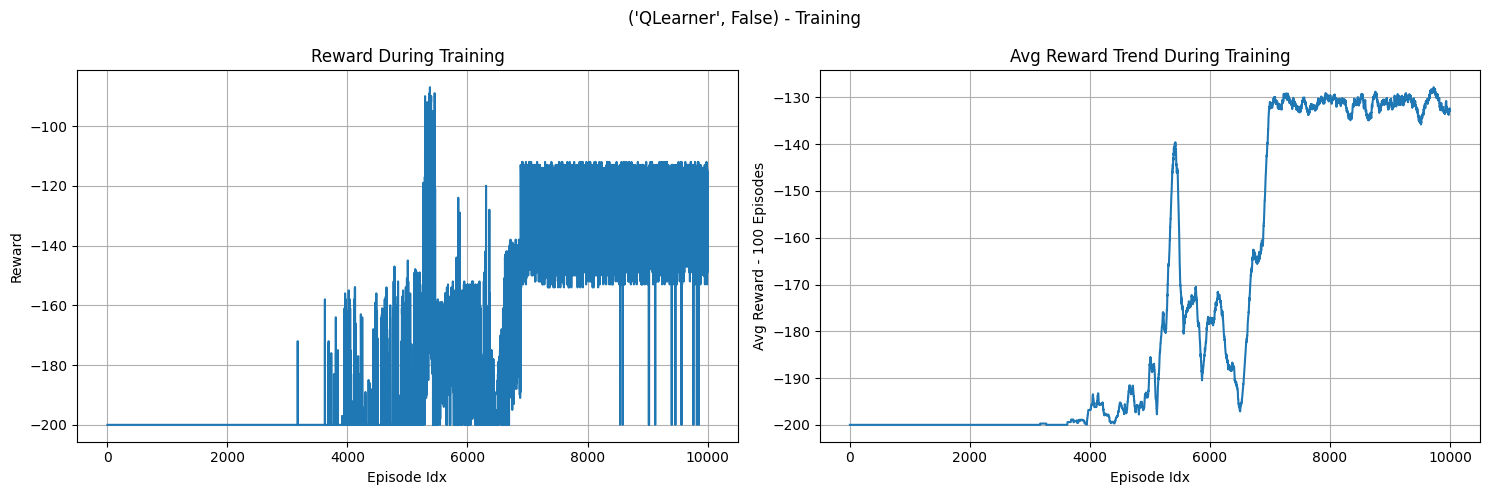

<Figure size 640x480 with 0 Axes>

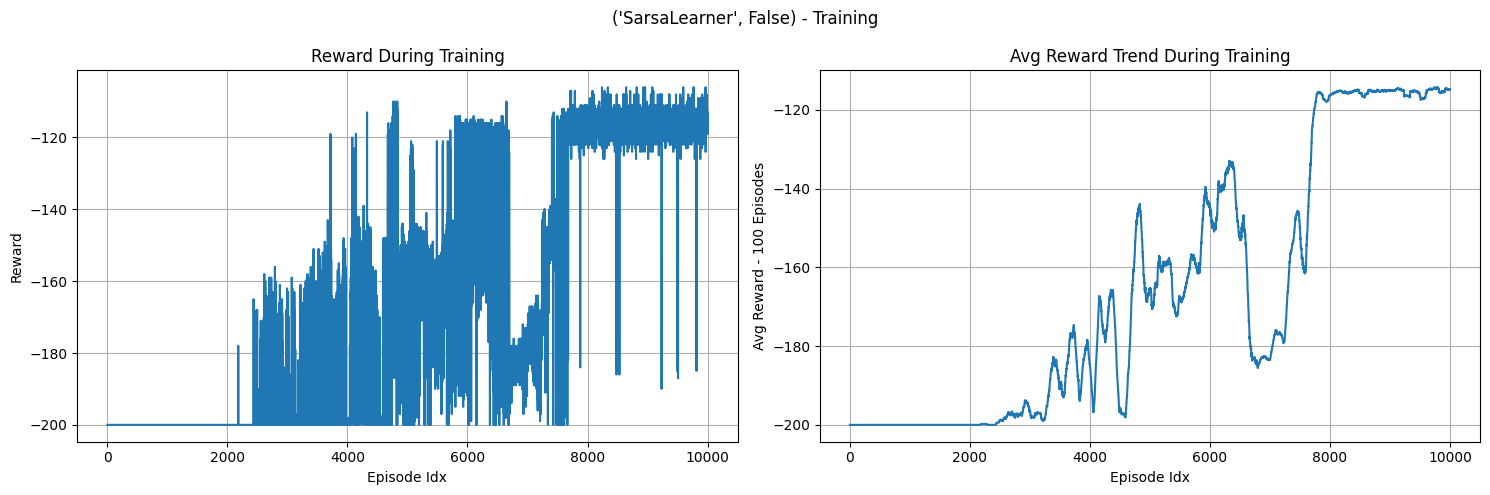

<Figure size 640x480 with 0 Axes>

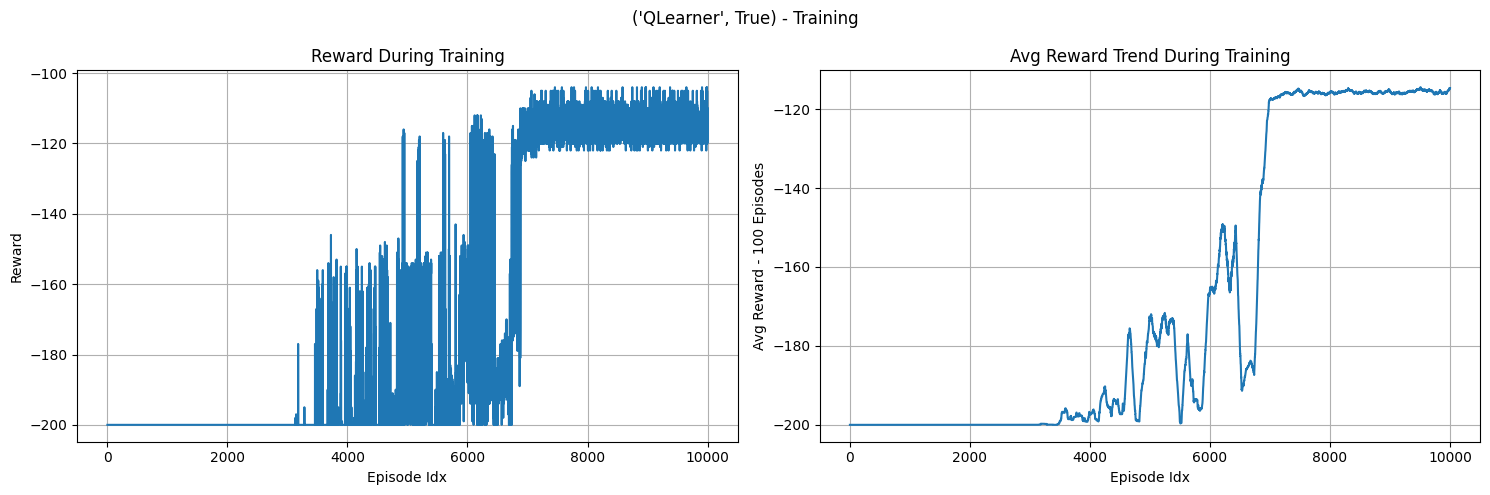

<Figure size 640x480 with 0 Axes>

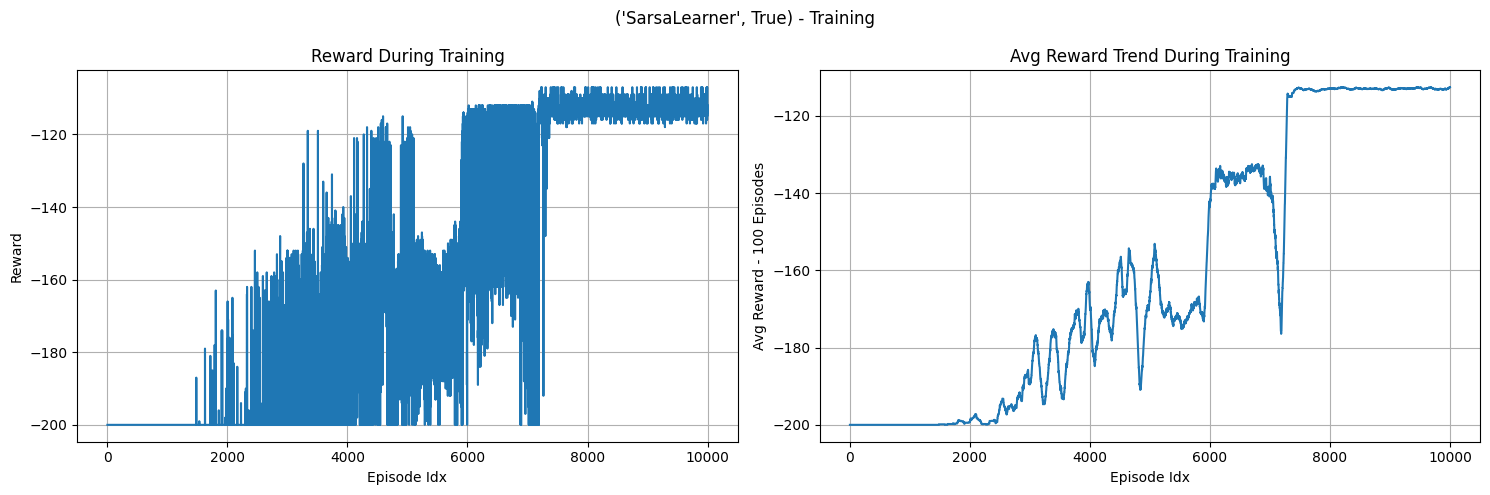

<Figure size 640x480 with 0 Axes>

In [130]:
if (os.path.exists(TRAINED_TABULAR_FILE)) :
    with open(TRAINED_TABULAR_FILE, 'rb') as f:
        trainDict = pickle.load(f)
else :
    trainDict = {}

qLearner, _ = trainLearner(QLearner, trainDict, bestDict, TRAIN_EPISODES, False)
sarsaLearner, _ = trainLearner(SarsaLearner, trainDict, bestDict, TRAIN_EPISODES, False)

qLearner_std, _ = trainLearner(QLearner, trainDict, bestDict, TRAIN_EPISODES, True)
sarsaLearner_std, _ = trainLearner(SarsaLearner, trainDict, bestDict, TRAIN_EPISODES, True)

## Testing

In [132]:
TESTING_EPISODES = 100

baseList = []
withStdList = []

for key in trainDict :
    if (key[1]) :
        withStdList.append(trainDict[key][0])
    else :
        baseList.append(trainDict[key][0])

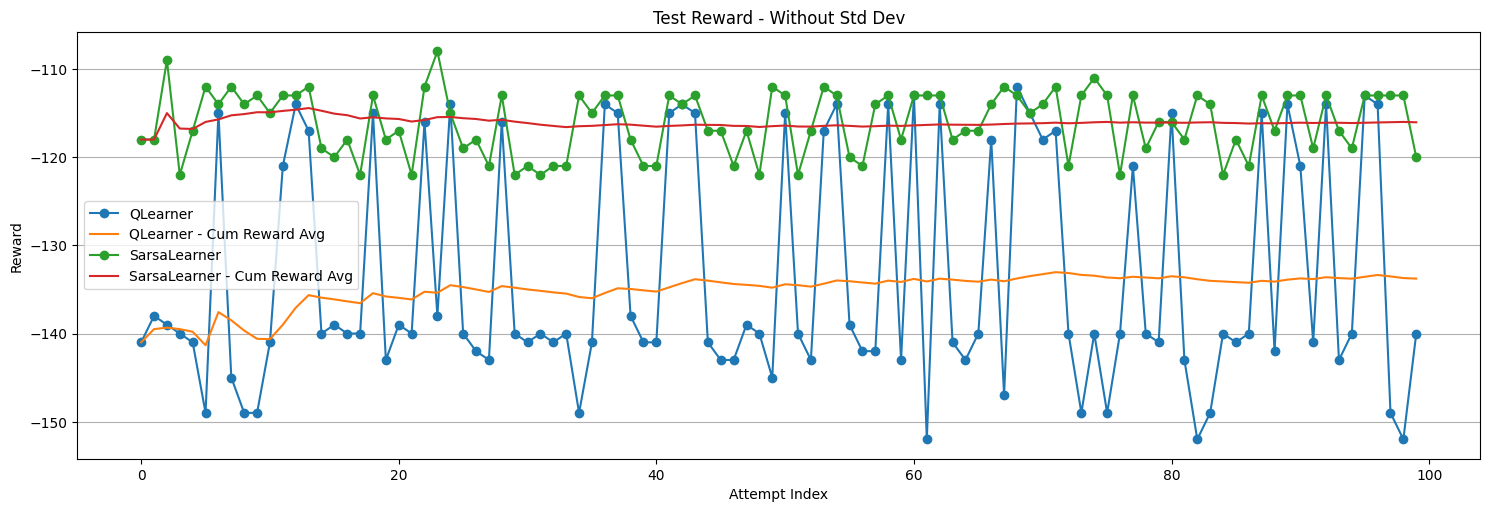

<Figure size 640x480 with 0 Axes>

In [135]:
plt.figure(figsize = (15, 5))
for learner in baseList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    plt.plot(rewardArray, label = learner.__class__.__name__, marker = "o")

    cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
    plt.plot(cumAvg, label = learner.__class__.__name__ + " - Cum Reward Avg")
plt.legend()
plt.grid(True, axis = "y")
plt.ylabel("Reward")
plt.xlabel("Attempt Index")
plt.tight_layout()
plt.title("Test Reward - Without Std Dev")
plt.show()
plt.clf()

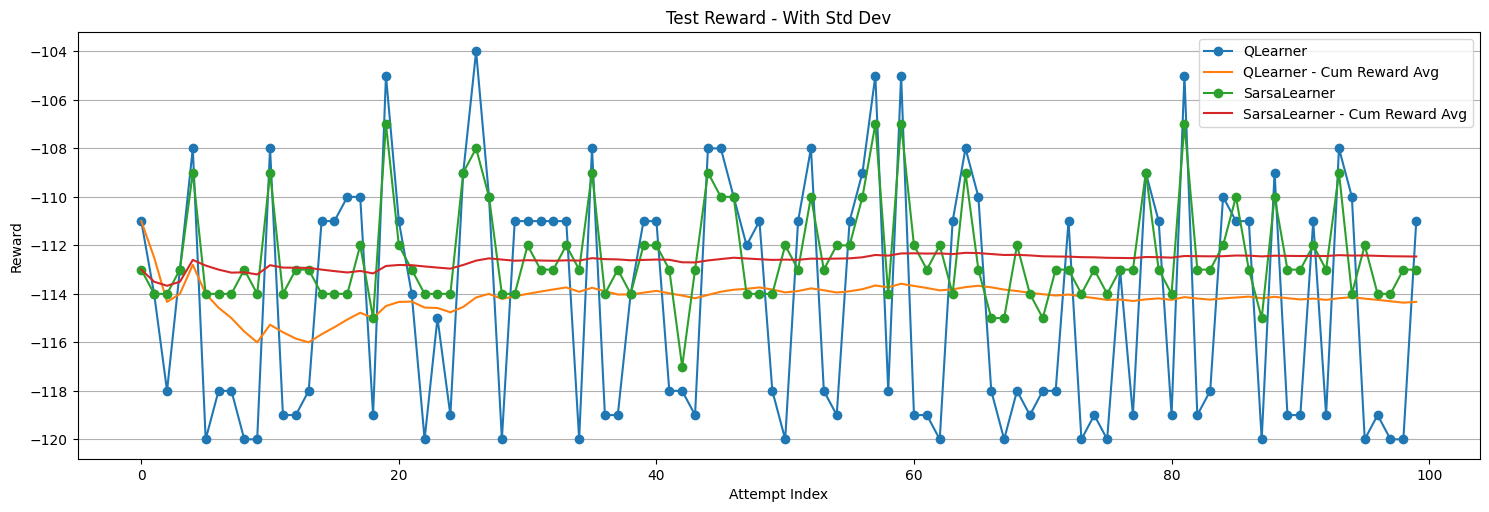

<Figure size 640x480 with 0 Axes>

In [136]:
plt.figure(figsize = (15, 5))
for learner in withStdList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    plt.plot(rewardArray, label = learner.__class__.__name__, marker = "o")

    cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
    plt.plot(cumAvg, label = learner.__class__.__name__ + " - Cum Reward Avg")
plt.legend()
plt.grid(True, axis = "y")
plt.ylabel("Reward")
plt.xlabel("Attempt Index")
plt.tight_layout()
plt.title("Test Reward - With Std Dev")
plt.show()
plt.clf()

In [140]:
table = buildTable("Testing Reward Info", ["LearnerName", "With Std", "Avg Reward", "Reward Std Dev", "Confidence Interval 95%"], [False, False, True, True, True])
for learner in baseList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(learner.__class__.__name__, str(False), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)

for learner in withStdList :
    rewardArray, _, _ = learner.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(learner.__class__.__name__, str(True), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)


Console().print(table)

                                           Testing Reward Info                                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ With Std ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ QLearner     │ False    │ -133.77    │ 12.977561404208421 │ -136.3580022568281 / -131.18199774317193  │
│ SarsaLearner │ False    │ -116.04    │ 3.571890255872932  │ -116.75231102326696 / -115.32768897673306 │
│ QLearner     │ True     │ -114.33    │ 4.845730079152161  │ -115.29634182572688 / -113.36365817427311 │
│ SarsaLearner │ True     │ -112.46    │ 2.026918843959965  │ -112.86421080503419 / -112.0557891949658  │
└──────────────┴──────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

# Soluzione con approssimazione

## Approssimazione con DQN

L'approssimazione con Deep Learning è stata realizzata con la libreria *stable-baseline3*. A causa di un conflitto tra le diverse versioni della libreria gymnasium (ovvero la vecchia *gym* e l'attuale *gymnasium*) è stata usata una versione più vecchia della libreria, cioè *stable-baseline3 v1.8.0*, la quale, usando solo la libreria *gym*, non genera questo conflitto. Questa versione risale al 2023-04-07, quindi comunque abbastanza recente.

La libreria sfrutta internamente *PyTorch* e risulta molto comoda in quanto offre trasparenza rispetto ai diversi algoritmi di QLearning, tra cui anche le DQN con Target Network.

In [148]:
env = gym.make(PROBLEM_NAME)
env.seed(seed = TRAIN_SEED)
env.action_space.seed(TRAIN_SEED + 10)

qNet = DQN(
    policy="MlpPolicy",
    env=env,
    verbose = 1,
    learning_rate=1e-3,
    buffer_size=50000,
    exploration_fraction=0.1,
    exploration_final_eps=0.1,
    policy_kwargs=dict(net_arch=[64]),
    seed=TRAIN_SEED
).learn(200 * 10_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5440     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5004     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200   

KeyboardInterrupt: 

In [76]:
# Use a separate environement for evaluation
eval_env = gym.make(PROBLEM_NAME)
eval_env.seed(TEST_SEED)
eval_env.action_space.seed(TEST_SEED + 10)

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(qNet, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/simone/Scrivania/University/ML/ML_ENV/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-200.00 +/- 0.00
